## Artist Name: F(u,N,k):tion
## Album Name: Derivative

## Attempt to Write Music from Scratch in Python

#### Ideas: 
 - functions like transpose
 - designer waveforms
 - mathematical expressions (lossless, scale to any quality?)
 - volume profiles (attack, sustain etc) - these are called envelopes
 - tracks are columns in a dataframe? rows is number of samples (play each row in sequence to play the piece)
 - analyse songs with ML
 - reconstruct some real songs (automatically?)
 - turn computer keyboard into realtime instrument with record capability, custom keybindings
 - allow input of samples from real tunes
 - fourier analysis
 - train NN or similar on samples of a sound type eg brass, then use to generate brass synths
 - launchpad keyboard functionality, try to do hydraulic II by Dimension with loops?
 - probabilistic music?

'FLAC supports from 4 to 32 bits per sample. Currently the reference encoder and decoders only support up to 24 bits per sample. Total samples in stream. 'Samples' means inter-channel sample, i.e. one second of 44.1Khz audio will have 44100 samples regardless of the number of channels.'

 \- xiph.org

'The human ear can nominally hear sounds in the range 20 Hz (0.02 kHz) to 20,000 Hz (20 kHz). ... Frequency resolution of the ear is about 3.6 Hz within the octave of 1000–2000 Hz. That is, changes in pitch larger than 3.6 Hz can be perceived in a clinical setting.'

\- https://en.wikipedia.org/wiki/Psychoacoustics

#### Conventions
- lengths are in samples, durations are in seconds.

#### Song Idea: Typhon
- anagram of python, convenient for a song written in python
- ancient Greek titan, 'Typhon was known as the father of all monsters. He was like a fire-breathing dragon with 100 heads, and he never slept.'
- 'The Greek poets described Typhon as “terrible, outrageous, and lawless,” “fell and cruel,” “strong and tireless,” and “the greatest plague on men and gods.” Without a doubt, he was the biggest bully in Greek mythology—and there wasn't a kind or merciful bone in his body.'
- son of Gaia (Earth) and Tartarus (Hell)
- defeated by zeus and imprisoned in Tartarus (the place) or possibly under mount Etna
- father of cerberus, hydra and chimaera
- monstrous serpentine giant, associated with volcanoes, hurricanes/typhoons (able to cause them with his wings)
- symbol is a simplified hurricane:

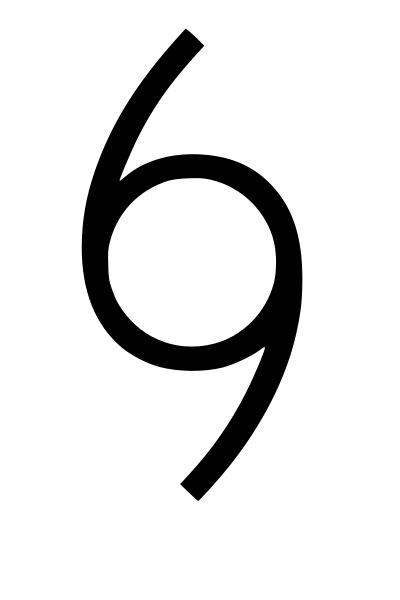

#### Song Idea: Armed Snobbery
- album art of man in period dress robbing modern people with a rapier
- harpsichord dubstep? or someting similarly ridiculous and contrasting

In [1]:
# Imports and settings
from sys import getsizeof
import numpy as np
import pandas as pd
pd.options.display.float_format = '{0:g}'.format

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import Audio

In [2]:
# Global default song parameters

# Fundamental
def_sample_rate = int(12000) # samples/second, normally between 12000 and 128000
def_duration = 210           # seconds
def_time_sig = (4, 4)        # (beats/bar, beat note id) e.g. (4, 4)
def_bpm = 60                 # beats/minute

# Typical bpms:
# Dub: 60-90, Hip-hop: 60-100, House: 115-130, Techno/trance: 120-140, Dubstep: 135-145, Drum and bass: 160-180

# Derived
def_length = round(def_sample_rate * def_duration) # samples
def_duration = def_length / def_sample_rate        # seconds
def_n_beats = def_duration * (def_bpm / 60)        # beats
def_beat_length = round(def_length / def_n_beats)  # samples
def_n_beats = def_length / def_beat_length         # beats
def_bar_length = def_beat_length * def_time_sig[0] # samples
def_n_bars = def_length / def_bar_length           # bars

# Note properties
def_beats_per_note = (2 * def_time_sig[1]) / (2 ** 1)        # beats
def_note_length = int(def_beats_per_note * def_beat_length)  # samples
def_note_duration = def_note_length / def_sample_rate        # seconds
def_note_template = np.zeros(def_note_length)                # array in sample space
def_note_freq = 440                                          # Hz or cycles per second, 440 Hz is A4
def_note_ssf = (2 * np.pi * def_note_freq) / def_sample_rate # cycles per sample, 'SSF' is 'Sample Space Frequency'

In [3]:
def repeat(target_list, filler_list):
    """
    Function to repeat a list or 1d array untill it has filled the length of a target (template) list or 1d array. Useful 
    to extend a sample to a required length, e.g. when you have created a sound and want to extend or cut that sound to 
    be the length of a certain note template. The values in the target list are irrelevant, a list is used instead of just 
    a length for convenience when matching to existing samples or templates.
    """
    
    if type(target_list) != 'list':
        
        target_list = list(target_list)
    
    if type(filler_list) != 'list':
        
        filler_list = list(filler_list)
    
    whole_lists = int(len(target_list) / len(filler_list))
    list_part = round(len(target_list) % len(filler_list))
    
    return np.array((filler_list * whole_lists) + filler_list[: list_part])

# Testing: 'repeat()'
# Note: filler can be longer than fillee

fillee = np.arange(10) + 1
filler = [i ** 3 for i in range(1, 5)]
print('fillee = ', fillee)
print('filler = ', filler)
rep = repeat(fillee, filler)
print('filled = ', rep)

fillee =  [ 1  2  3  4  5  6  7  8  9 10]
filler =  [1, 8, 27, 64]
filled =  [ 1  8 27 64  1  8 27 64  1  8]


In [7]:
class song:
    
    def __init__(self, 
                 sample_rate = def_sample_rate, 
                 duration = def_duration, 
                 time_sig = def_time_sig, 
                 bpm = def_bpm):
        
        self.sample_rate = sample_rate # samples/second (Hz)
        self.duration = duration       # seconds
        self.time_sig = time_sig       # (beats/bar, beat note id) e.g. (4, 4)
        self.bpm = bpm                 # beats/minute
        
        self.length = round(self.sample_rate * self.duration) # samples
        self.duration = self.length / self.sample_rate        # seconds
        self.n_beats = self.duration * (self.bpm / 60)        # beats
        self.beat_length = round(self.length / self.n_beats)  # samples
        self.n_beats = self.length / self.beat_length         # beats
        self.bar_length = self.beat_length * self.time_sig[0] # samples
        self.n_bars = self.length / self.bar_length           # bars
        
        # Establish a dictionary for different types of wave e.g. sawtooth
        self.wavefunctions = dict(square = lambda freq, amp, xs: 
                                  -1 * (2 * amp) * np.array([int(x / (len(xs) / 2)) % 2 for x in xs]) + (2 * amp), 
                                  
                                  sin = lambda freq, amp, xs: 
                                  repeat(np.arange(len(xs)), 
                                         (amp * np.sin(((2 * np.pi * freq) / self.sample_rate) * 
                                                       np.arange(np.lcm(self.sample_rate, freq))) + amp)))
        
        # Dictionaries to store created waveforms, volume envelopes, notes and melodies
        self.waveforms = dict()
        self.envelopes = dict()
        self.notes = dict()
        self.melodies = dict()
        
        # Creates tracks to index by sample, bar and beat
        sample_ns = [i for i in range(self.length)]
        bar_ns = np.array([int(i / self.bar_length) for i in range(self.length)])
        beat_ns = np.array([int(i / self.beat_length) for i in range(int(self.length))])        
        
        # This creates the dataframe that will hold the actual audio data, along with some other useful columns
        self.df = pd.DataFrame(dict(sample_ns = sample_ns, 
                               bar_ns = bar_ns, 
                               beat_ns = beat_ns))
        
    def note_info(self):
        """
        Defines properties for the eight standard note types based on song metadata (bpm, time_sig etc).
        """
        
        note_types = ['Breve', 'Semibreve', 'Minim', 'Crotchet', 'Quaver', 
                      'Semiquaver', 'Demisemiquaver', 'Hemidemisemiquaver']

        beat_note = note_types[int(np.log2(self.time_sig[1])) + 1]
        
        note_lengths = [((2 * self.time_sig[1]) / (2 ** i)) * self.beat_length for i in range(len(note_types))]
            
        note_lengths = pd.Series(data = note_lengths, index = note_types)
        note_durations = pd.Series(data = note_lengths / self.sample_rate)
        note_beats = pd.Series(data = note_durations * (self.bpm / 60))
        note_bars = pd.Series(data = note_beats / self.time_sig[0])
        
        note_info_df = pd.DataFrame(dict(note_length = note_lengths, 
                                         note_duration = note_durations, 
                                         note_beats = note_beats, 
                                         note_bars = note_bars))
        
        display(note_info_df
                .style.format('{0:g}')
                .applymap(lambda val: 'font-weight: bold', 
                          subset = pd.IndexSlice[note_info_df.index[note_info_df.index == beat_note], :]))
        
        return note_info_df
    
    def info(self):
        """
        Reports key information about the song and it's structure.
        """
        
        return pd.Series(dict(sample_rate = self.sample_rate, 
                              duration = self.duration, 
                              time_sig = str(self.time_sig), 
                              bpm = self.bpm, 
                              length = self.length, 
                              n_bars = self.n_bars, 
                              n_beats = self.n_beats, 
                              bar_length = self.bar_length, 
                              beat_length = self.beat_length, 
                              n_bytes = getsizeof(self.df)))
    
    def waveform(self, 
                 template = def_note_template, 
                 functions = None, 
                 rel_lengths = [1], 
                 param_tuples = [(440, 0.5)], 
                 name = 'Default', 
                 graph = 0):
        """
        Used to create either pure or composite waveforms (for example a sine wave that changes to a sawtooth at one third 
        of its length). Defaults to making a pure sine wave at 440 Hz with a duration of one beat.
        """
        
        functions = functions or [self.wavefunctions['sin']]

        xs = np.array(range(len(template)))
        ys = np.zeros(len(template))

        normalised_lengths = [round((rel_length / sum(rel_lengths)) * len(xs)) for rel_length in rel_lengths]
        start_idxs = [sum(normalised_lengths[:i]) for i in range(len(normalised_lengths))]

        function_n = 0
        for function, param_tuple, length, start_idx in zip(functions, param_tuples, normalised_lengths, start_idxs):

            section_xs = xs[:length]
            section_ys = function(*param_tuple, section_xs)

            ys[start_idx: start_idx + length] += section_ys

            if graph:

                plt.title('Function {}'.format(function_n))
                samples_plot(section_ys)

            function_n += 1
        
        self.waveforms[name] = ys
        
        if graph:

            plt.title('Combined Waveform: {}'.format(name))
            samples_plot(ys)

        return ys
    
    def spectrum(self, track):
        
        sample_rate = self.sample_rate
        
        #whole_cycles_track = track[: int(sample_rate / )]
        
        frequencies = np.arange(int(len(track) / 2)) * (sample_rate / len(track))
        amplitudes = abs(np.fft.fft(track - np.mean(track)) / len(track))[range(int(len(track) / 2))]
        
        fundamental = np.argmax(amplitudes) * (sample_rate / len(track))

        return (frequencies, amplitudes, fundamental)
    
    def samples_plot(self, track, show_spec = True):
        
        sample_rate = self.sample_rate
        spec = self.spectrum(track)
        
        if show_spec:
            
            fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (16, 8))
            
            ax[1].plot(spec[0], spec[1], 'k')
            ax[1].set_xlabel('Frequency (Hz)')
            ax[1].set_title('Frequency Domain')
            ax[1].set_xlim(0, min(sample_rate / 2, 20000))
            
        else:
            
            fig, ax = plt.subplots(constrained_layout = True)
            
            ax = [ax]
        
        def samples2secs(samples):

            return  samples / sample_rate

        def secs2samples(secs):

            return sample_rate * secs
        
        ax[0].plot(np.arange(len(track)), track, '-r+', label = 'f = {0:g} Hz'.format(spec[2]))
        ax[0].plot(np.arange(len(track)), (track * 0) + (max(track) / 2), 'k', 
                   label = 'Half Amplitude = {:.3g}'.format((max(track) / 2)))
        ax[0].plot(np.arange(len(track)), (track * 0) + np.mean(track), 'b--', 
                   label = 'Mean Level = {:.3g}'.format(np.mean(track)))
        secax = ax[0].secondary_xaxis('top', functions = (samples2secs, secs2samples))
        ax[0].set_ylim(0, 1.1)
        ax[0].legend(loc = 1)
        ax[0].set_title('Time Domain')
        ax[0].set_xlabel('Samples')
        secax.set_xlabel('Time (Seconds)')
        
        return ax

In [8]:
# Establishing a 'song' object and reporting some of its properties
my_song = song()
my_song_info = my_song.info()
print(my_song_info)
my_notes = my_song.note_info()

sample_rate       12000
duration            210
time_sig         (4, 4)
bpm                  60
length          2520000
n_bars             52.5
n_beats             210
bar_length        48000
beat_length       12000
n_bytes        40320144
dtype: object


,note_length,note_duration,note_beats,note_bars
Breve,96000,8,8,2
Semibreve,48000,4,4,1
Minim,24000,2,2,0.5
Crotchet,12000,1,1,0.25
Quaver,6000,0.5,0.5,0.125
Semiquaver,3000,0.25,0.25,0.0625
Demisemiquaver,1500,0.125,0.125,0.03125
Hemidemisemiquaver,750,0.0625,0.0625,0.015625


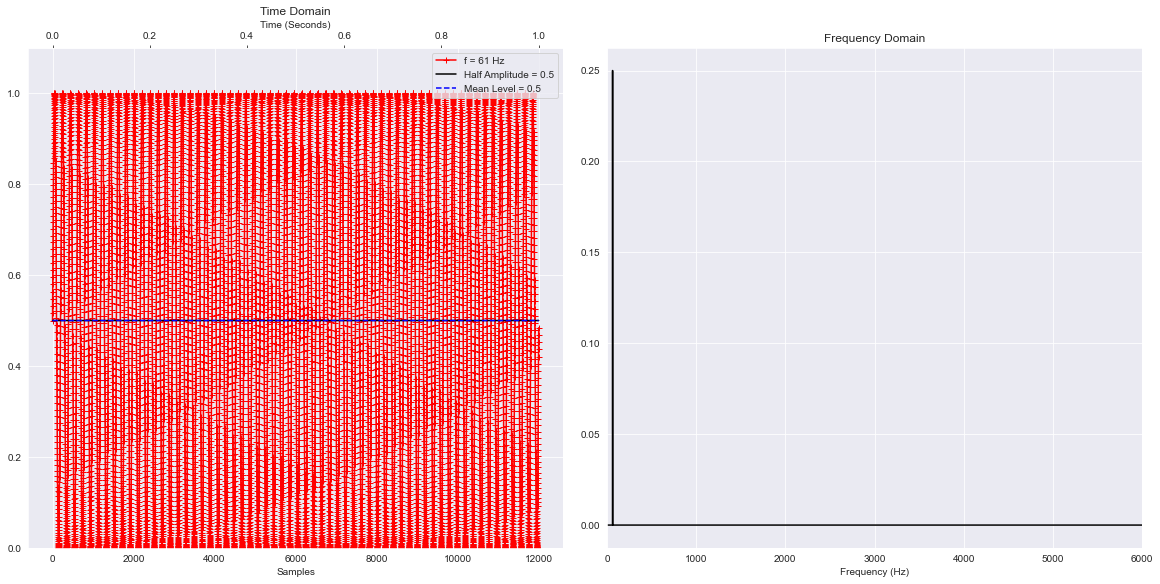

In [51]:
my_plot_sample = my_song.waveform(param_tuples = [(61, 0.5)], template = np.zeros(int(my_notes.note_length['Crotchet'])))
#my_plot_sample += my_song.waveform(param_tuples = [(30, 0.5)], template = np.zeros(int(my_notes.note_length['Quaver'])))
#my_plot_sample = my_plot_sample / (max(my_plot_sample) - min(my_plot_sample))
my_plot = my_song.samples_plot(my_plot_sample)

In [52]:
def find_fundamental(track):
    
    sample_rate = def_sample_rate
    #sample_rate = self.sample_rate
    
    track -= (min(track) + ((max(track) - min(track)) / 2))
    
    zero_crossings = np.where(np.diff(np.sign(track)))[0]
    grads = np.round(np.diff(track)[zero_crossings], 8)
    #print(grads)
    grad_matches = [list(np.where(grads == grads[i])[0]) for i in range(len(grads))]
    
    unique_grad_matches = {}
    for grad_match in grad_matches:
        
        unique_grad_matches.setdefault(tuple(grad_match))

    grad_matches = list(unique_grad_matches.keys())
    #print(grad_matches)
    
    consec_pairs = [[(grad_match[i - 1], grad_match[i]) for i in range(1, len(grad_match))] for grad_match in grad_matches]
    #first_twos = [grad_match[:2] for grad_match in grad_matches]
    #print(consec_pairs)
    crossing_idxs = [[list(zero_crossings[list(pair)]) for pair in grad_match] for grad_match in consec_pairs]
    crossing_idxs = [pair for pair_set in crossing_idxs for pair in pair_set]
    #crossing_idxs = [zero_crossings[list(first_two)] for first_two in first_twos]
    #print(crossing_idxs)
    #print(len(crossing_idxs))
    wavelengths = np.unique([crossing_idx[1] - crossing_idx[0] for crossing_idx in crossing_idxs])
    #print(wavelengths)
    fundamental_length = max(wavelengths) # samples
    fundamental_period = fundamental_length / sample_rate # seconds
    fundamental_frequency = 1 / fundamental_period # Hz
    #print(fundamental_frequency)
    
    #print([[grad_match[n] - grad_match[n - 1] for n in range(1, len(grad_match))] for grad_match in grad_matches])
    
    return fundamental_frequency

temp = find_fundamental(my_plot_sample)
temp

1.0166906718630857

In [55]:
for i in range(1, 101):

    my_plot_sample = my_song.waveform(param_tuples = [(i, 0.5)], template = np.zeros(int(my_notes.note_length['Crotchet'])))
    #print(i, ':', find_fundamental(my_plot_sample))
    print(i)
    print(find_fundamental(my_plot_sample))

1


ValueError: max() arg is an empty sequence

In [24]:
def find_fundamental(track):
    
    sample_rate = def_sample_rate
    #sample_rate = self.sample_rate
    
    track -= (min(track) + ((max(track) - min(track)) / 2))
    
    zero_crossings = np.where(np.diff(np.sign(track)))[0]
    #print(zero_crossings)
    grads = np.round(np.diff(track)[zero_crossings], 10)
    #print(grads)
    grad_matches = [list(np.where(grads == grads[i])[0]) for i in range(len(grads))]
    #print(grad_matches)
    
    unique_grad_matches = {}
    for grad_match in grad_matches:
        
        unique_grad_matches.setdefault(tuple(grad_match))

    grad_matches = list(unique_grad_matches.keys())
    print(grad_matches)
    
    first_twos = [grad_match[:2] for grad_match in grad_matches]
    print(first_twos)
    
    crossing_idxs = [zero_crossings[list(first_two)] for first_two in first_twos]
    print(crossing_idxs)
    wavelengths = [crossing_idx[1] - crossing_idx[0] for crossing_idx in crossing_idxs]
    fundamental_length = max(wavelengths)
    fundamental_period = fundamental_length / sample_rate
    print(fundamental_period)
    
    print([[grad_match[n] - grad_match[n - 1] for n in range(1, len(grad_match))] for grad_match in grad_matches])
    
    return grad_matches

temp = find_fundamental(my_plot_sample)
#temp[1]

[(0, 22, 44, 66, 88, 110, 132, 154, 176, 198, 220, 242, 264, 286, 308, 330, 352, 374, 396, 418, 440, 462, 484, 506, 528, 550, 572, 594, 616, 638, 660, 682, 704, 726, 748, 770, 792, 814, 836, 858), (1, 21, 23, 43, 45, 65, 67, 87, 89, 109, 111, 131, 133, 153, 155, 175, 177, 197, 199, 219, 221, 241, 243, 263, 265, 285, 287, 307, 309, 329, 331, 351, 353, 373, 375, 395, 397, 417, 419, 439, 441, 461, 463, 483, 485, 505, 507, 527, 529, 549, 551, 571, 573, 593, 595, 615, 617, 637, 639, 659, 661, 681, 683, 703, 705, 725, 727, 747, 749, 769, 771, 791, 793, 813, 815, 835, 837, 857, 859, 879), (2, 20, 24, 42, 46, 64, 68, 86, 90, 108, 112, 130, 134, 152, 156, 174, 178, 196, 200, 218, 222, 240, 244, 262, 266, 284, 288, 306, 310, 328, 332, 350, 354, 372, 376, 394, 398, 416, 420, 438, 442, 460, 464, 482, 486, 504, 508, 526, 530, 548, 552, 570, 574, 592, 596, 614, 618, 636, 640, 658, 662, 680, 684, 702, 706, 724, 728, 746, 750, 768, 772, 790, 794, 812, 816, 834, 838, 856, 860, 878), (3, 19, 25, 41, 47,

In [211]:
[l[x] for x in (temp[1])]

[300, 2100, 3900, 5700, 7500]

In [163]:
Output = {}
for lis in find_fundamental(my_plot_sample): 
    Output.setdefault(tuple(lis), list()).append(1) 

Output

[[0, 2, 4], [1, 3], [0, 2, 4], [1, 3], [0, 2, 4]]


{(0, 2, 4): [1, 1, 1], (1, 3): [1, 1]}

In [181]:
Output = {}
for lis in find_fundamental(my_plot_sample): 
    Output.setdefault(tuple(lis))

list(Output.keys())

[[0, 2, 4], [1, 3], [0, 2, 4], [1, 3], [0, 2, 4]]
dict_keys([(0, 2, 4), (1, 3)])


[(0, 2, 4), (1, 3)]

In [111]:
#vals = np.diff(my_plot_sample)[find_fundamental(my_plot_sample)]
vals = [1, 2, 3, 4, 5, 1, 7, 8, 9, 10, 1, 12, 3, 14, 15, 1]
np.round(vals, 8)

array([ 1,  2,  3,  4,  5,  1,  7,  8,  9, 10,  1, 12,  3, 14, 15,  1])

In [78]:
[i for i in range(len(vals)) if np.round(vals[i], 8) in np.round(vals[:max(0, i - 1)], 8)]

[5, 10, 15]

In [90]:
#print(np.where(np.round(vals, 8) == np.round(vals[0], 8))[0])
i = 5
np.round(list(vals[:i]) + [np.nan] + list(vals[i+1:]), 8)

array([ 1.,  2.,  3.,  4.,  5., nan,  7.,  8.,  9., 10.,  1., 12., 13.,
       14., 15.,  1.])

In [95]:
[np.where(np.round(list(vals[:i]) + [np.nan] + list(vals[i+1:]), 8) == np.round(vals[i], 8))[0] for i in range(len(vals))]

[array([ 5, 10, 15], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([ 0, 10, 15], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([ 0,  5, 15], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([ 0,  5, 10], dtype=int64)]

In [99]:
set([np.where(np.round(vals, 8) == np.round(vals[i], 8))[0] for i in range(len(vals))])

TypeError: unhashable type: 'numpy.ndarray'

In [112]:
l = np.unique([list(np.where(np.round(vals, 8) == np.round(vals[i], 8))[0]) for i in range(len(vals))])
print(max(l, key=len))

[0, 5, 10, 15]


In [113]:
l

array([list([0, 5, 10, 15]), list([1]), list([2, 12]), list([3]),
       list([4]), list([6]), list([7]), list([8]), list([9]), list([11]),
       list([13]), list([14])], dtype=object)

In [115]:
[ele for ele in l if len(ele) > 1]

[[0, 5, 10, 15], [2, 12]]

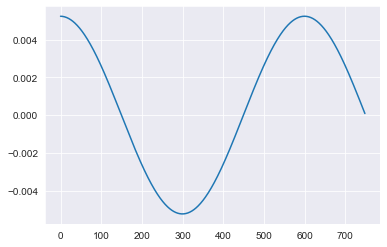

In [28]:
plt.plot(np.arange(len(np.diff(my_plot_sample))), np.diff(my_plot_sample))

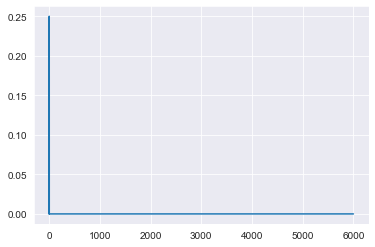

Fundamental frequency: 4.0Hz


In [17]:
def spectrum(track):
    
    frequencies = np.arange(int(len(track) / 2)) * (def_sample_rate / len(track))
    amplitudes = abs(np.fft.fft(track - np.mean(track)) / len(track))[range(int(len(track) / 2))]
    
    fundamental = np.argmax(amplitudes) * (def_sample_rate / len(track))

    return (frequencies, amplitudes, fundamental)

my_spec = spectrum(my_plot_sample)

plt.plot(my_spec[0], my_spec[1])
plt.show()
print('Fundamental frequency: {} Hz'.format(my_spec[2]))

In [27]:
f = 440
sr = 12000
#note_durations = [0.25, 0.3333333, 0.5, 1, 2, 2.5, 7, 9, 13, 27, 163, 281]
note_durations = [4]

for duration in my_notes.note_duration:
    
    perf = repeat(np.arange(round(duration * sr)), 
                  (0.5 * np.sin(((2 * np.pi * f) / sr) * np.arange(np.lcm(sr, f))) + 0.5))
    
    perf_spec = my_song.spectrum(perf)

    max_idx = np.argmax(perf_spec[1])
    fundamental = max_idx * (sr / len(perf))
    print('Duration: {}'.format(duration))
    print('Fundamental frequency: {:.4g}'.format(fundamental))


Duration: 8.0
Fundamental frequency: 440
Duration: 4.0
Fundamental frequency: 440
Duration: 2.0
Fundamental frequency: 440
Duration: 1.0
Fundamental frequency: 440
Duration: 0.5
Fundamental frequency: 440
Duration: 0.25
Fundamental frequency: 440
Duration: 0.125
Fundamental frequency: 440
Duration: 0.0625
Fundamental frequency: 432


In [295]:
# needs fixing, use turning points to find peaks

def components(track, n_largest = 10):
    
    spec = spectrum(track)[1]
    cut_spec = spec
    
    freqs = np.zeros(n_largest)
    rel_amps = np.zeros(n_largest)
    peak_index = 0
    
    for component_n in range(n_largest):
        
        cut_spec = cut_spec[peak_index + 80:]
        
        peak_index = np.argmax(cut_spec)
        print(peak_index)
        
        freqs[component_n] = peak_index / 4
        rel_amps[component_n] = spec[peak_index] / max(spec)
    
    return pd.DataFrame(dict(frequency = freqs, relative_amplitude = rel_amps))

components(my_plot_sample)

1698
1698
1697
1698
1698
1698
5253
1698
5253
808


,frequency,relative_amplitude
0,424.50,0.002797
1,424.50,0.002797
2,424.25,0.002763
3,424.50,0.002797
4,424.50,0.002797
5,424.50,0.002797
6,1313.25,0.000080
7,424.50,0.002797
8,1313.25,0.000080
9,202.00,0.000258


<class 'numpy.ndarray'>


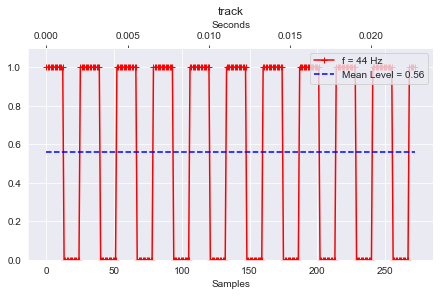

In [187]:
my_square_wave = my_song.waveform(functions = [my_song.wavefunctions['square']], param_tuples = [(440, 0.5)])
#my_song.samples_plot(my_square_wave)
my_song.samples_plot(my_square_wave[:round(10 * (my_song.sample_rate / 440))])

2520000


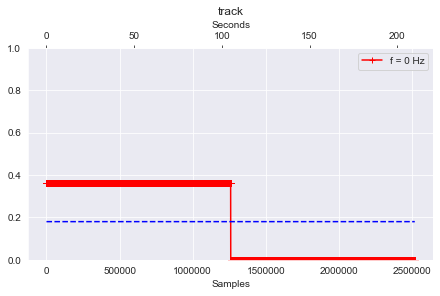

In [10]:
my_song.samples_plot(my_song.wavefunctions['square'](0.36, my_song.df.sample_ns))

In [7]:
my_song.waves.keys()

dict_keys(['Untitled'])

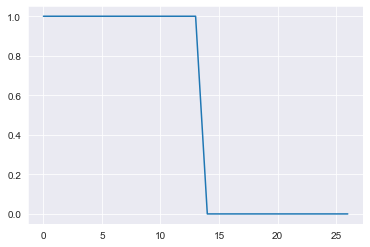

In [67]:
freq = 440
amp = 0.5
xs = np.array(range(round(def_sample_rate / freq)))

#ys = np.array([int(x / (((2 * np.pi * freq) / def_sample_rate) * (len(xs) / 2))) % 2 for x in xs])
ys = np.array([int(x / (len(xs) / 2)) % 2 for x in xs])
ys = (-1 * (2 * amp) * ys) + (2 * amp)

plt.plot(xs, ys)
plt.show()

In [8]:
my_song.waveform(name = 'my_wave')
my_song.waves.keys()

dict_keys(['Untitled', 'my_wave'])

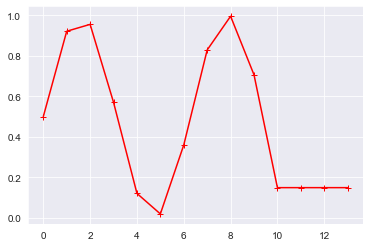

In [9]:
sin_flat = my_song.waveform(np.array(range(14)), 
                            [(lambda a, b, xs: a * np.sin(b * xs) + a), (lambda a, xs: np.array([a] * len(xs)))], 
                            [3, 1], 
                            [(0.5, 1), (0.15, )])

samples_plot(sin_flat)

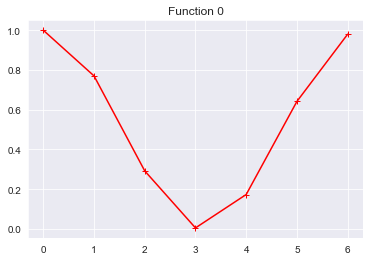

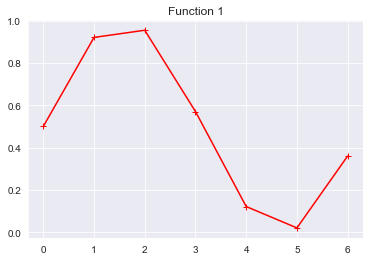

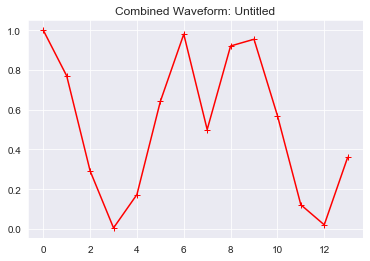

In [10]:
cos_sin = my_song.waveform(np.array(range(14)), 
                           [(lambda a, b, xs: (a * np.cos(b * xs) + a)), 
                            (lambda a, b, xs: (a * np.sin(b * xs) + a))], 
                           [1, 1], 
                           [(0.5, 1), (0.5, 1)], graph = 1)

In [11]:
my_song.waves.keys()

dict_keys(['Untitled', 'my_wave'])

In [12]:
my_song.waves['Untitled'] = sin_flat
my_song.waves['my_wave'] = cos_sin

new_keys = ['sin_flat', 'cos_sin']

In [13]:
def rename_dict_keys(dictionary, new_keys):
    
    return {key.replace(key, new_key): value 
            for key, value, new_key 
            in zip(my_song.waves.keys(), my_song.waves.values(), new_keys)}

In [14]:
my_song.waves = rename_dict_keys(my_song.waves, new_keys)

In [15]:
my_song.waves.keys()

dict_keys(['sin_flat', 'cos_sin'])

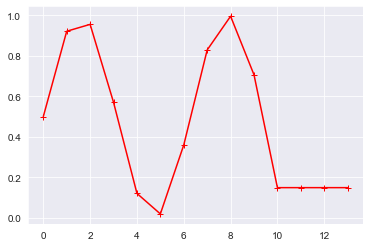

In [16]:
samples_plot(my_song.waves['sin_flat'])

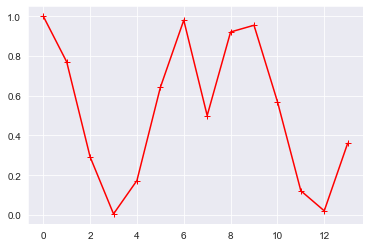

In [17]:
samples_plot(my_song.waves['cos_sin'])

In [4]:
box_wave = lambda level, xs: (-1 * level * np.array([int(x / (len(xs) / 1.5)) % 2 for x in xs])) + level

samples_plot(box_wave(0.5, np.array(range(100))))

NameError: name 'samples_plot' is not defined

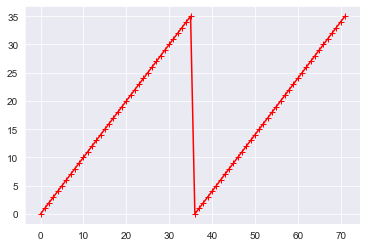

In [31]:
xs = np.array(range(72))
samples_plot([int(x % (len(xs) / 2)) for x in xs])

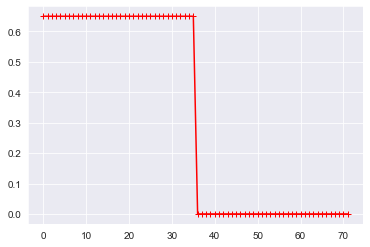

In [53]:
level = 0.65
box = (-1 * level * np.array([int(x / (len(xs) / 2)) % 2 for x in xs])) + level
samples_plot(box)